## Load modules and global variables 

In [1]:
import pandas as pd
import numpy as np 
import psycopg2
import json
from pathlib import Path
from scipy import sparse
import matplotlib.pyplot as plt
from queries import ICD_QUERY, ADMISSIONS_QUERY

In [2]:
# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


# models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm 

# evaluation 
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, auc
from scipy import stats

In [3]:
ICD_CM_9_TO_10_MAPPING_FILE = "../data/icd_cm_9_to_10_mapping.csv.gz"
ICD_CM_10_TO_9_MAPPING_FILE = "../data/icd_cm_10_to_9_mapping.csv"
ICD_CM_9_TITLE_FILE = "../data/icd9dx2015.csv"
RANDOM_STATE = 318

## Load custom class and function

In [4]:
def connect_to_database(cdict:dict):
    """Connect to database
    @var cdict (str[str]) : credentials 
    
    @return cn : connection to schema 
    @return cur : cursor of the connection 
    """
    # Connect to local postgres version of mimic
    schema_name=cdict["schema_name"]
    # dbname=cdict["dbname"]
    try:
        cn = psycopg2.connect(
            host=cdict["host"],
            port=cdict["port"],
            user=cdict["user"],
            password=cdict["password"],
            dbname=cdict["dbname"],  # Replace with your actual database name
            options="-c client_encoding=UTF8"
        )
        print("Connected to the PostgreSQL server successfully!")

        print('Connected to postgres {}.{}.{}!'.format(int(cn.server_version/10000),
                                                    (cn.server_version - int(cn.server_version/10000)*10000)/100,
                                                    (cn.server_version - int(cn.server_version/100)*100)))
        cur = cur = cn.cursor()
        set_schema_path = f"SET search_path to {schema_name}; COMMIT;"
        cur.execute(set_schema_path)
        return cn, cur 
    
    except psycopg2.Error as error:
        print(error)
        return None, None

In [5]:
def create_icd_translation(is_9_to_10:bool=True):
    """Return a dict that maps icd codes from one of versions to the other one (9 to 10 or 10 to 9)
    @return version_mapping (str[str])
    """
    if is_9_to_10:
        version_mapping = pd.read_csv(ICD_CM_9_TO_10_MAPPING_FILE, dtype=str)
        version_mapping.drop_duplicates(subset="icd_9", inplace=True)
        version_mapping = version_mapping.groupby("icd_9").icd_10.apply(
            lambda values: min(values, key=len)
        )
    else:
        version_mapping = pd.read_csv(ICD_CM_10_TO_9_MAPPING_FILE, dtype=str)
        version_mapping.drop_duplicates(subset="icd10cm", inplace=True)
        version_mapping = version_mapping.groupby("icd10cm").icd9cm.apply(
            lambda values: min(values, key=len)
        )        
    return version_mapping.to_dict()

In [6]:
def create_icd_9_titles(mode="mix"):
    title_mapping = pd.read_csv(ICD_CM_9_TITLE_FILE, dtype=str)
    
    # Ensure required columns exist
    required_columns = {'dgns_cd', 'longdesc', 'shortdesc'}
    if not required_columns.issubset(title_mapping.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(title_mapping.columns)}")
    
    # Drop duplicate diagnosis codes
    title_mapping = title_mapping.drop_duplicates(subset='dgns_cd')
    
    # Apply the logic to select the appropriate description
    title_mapping['mixdesc'] = title_mapping.apply(
        lambda row: row['longdesc'] if len(row['longdesc']) < 30 else row['shortdesc'], axis=1
    )
    
    # Convert to dictionary
    if mode == "mix":
        return title_mapping.set_index('dgns_cd')['mixdesc'].to_dict()
    elif mode == "long":
        return title_mapping.set_index('dgns_cd')['longdesc'].to_dict()
    elif mode == "short":
        return title_mapping.set_index('dgns_cd')['shortdesc'].to_dict()
    else: 
        raise ValueError("Wrong mode for creating titles")

In [7]:
def translate_icd(version_mapping:dict, left_digits:int|None,
                  df:pd.DataFrame, from_version:int=9, to_version:int=10, version_col:str='icd_version', code_col:str="icd_code") -> pd.DataFrame:
    """Map df icd code columns from version 9 to version 10
    @var version_mapping (str[str]) : dict that maps between icd code 9 and 10 
    @var left_digits (int) : icd code rolled up to certain left digits 
    @var df (pd.Dataframe) 
    @var version_col (str)
    @var code_col (str)

    @return df (pd.DataFrame) 
    """
    assert from_version == 9 or from_version == 10
    assert to_version == 9 or to_version == 10

    df_new = df.copy()
    
    is_from_version = df_new[version_col] == from_version
    df_new[code_col] = df_new[code_col].astype(str).str.strip()

    # Function to map based on original and truncated lengths
    def map_code(code):
        original_code = code
        while len(code) > 0:  # Keep reducing the code until it's empty
            mapped = version_mapping.get(code)
            if mapped is not None:
                return mapped
            code = code[:-1]  # Remove the last character and try again
        return original_code

    df_new.loc[is_from_version, code_col] = df_new.loc[is_from_version, code_col].apply(map_code)
    
    # Update icd_version to 10 for successfully mapped codes
    mask = is_from_version & df_new[code_col].isin(version_mapping.values())
    df_new.loc[mask, version_col] = to_version

    # roll up icd codes
    if left_digits is not None:
        df_new[code_col] = df_new[code_col].apply(lambda x: x[:left_digits] if len(x) > left_digits else x)

    return df_new

In [8]:
def load_query_data(path:str, query:str, cn):
    """Query data or load data if data are pre-saved. 
    @var path (str) 
    @var query (str)
    @var cn : connection to schema 

    @return df (pd.DataFrame)
    """
    path = Path(path).resolve()
    
    # if data pre-saved -> load 
    # else if connection to database is successful -> query data 
    # else : error
    if path.exists():
        df = pd.read_csv(path)
        return df
    elif cn is not None:
        df = pd.read_sql(query, cn)
        df.to_csv(path, compression="gzip", index=False)
        return df
    else:
        raise ValueError(f"{path} does not exist and fail to connect to PostgreSQL.")

In [9]:
def get_icd_code_dummies(data_path:str, col_path:str, df:pd.DataFrame, key_col="hadm_id", code_col="icd_code") -> pd.DataFrame:
    """Get dummies of icd codes for each key columns or load dummies if data are pre-saved. 
    @var data_path (str)
    @var col_path (str)
    @var df (pd.Dataframe) : df contains icd codes 
    @var key_col (str) : key column for groupby 
    @var code_col (str) 

    @return icd_dummies (pd.DataFrame) : key_col, icd_cols 
    """
    data_path = Path(data_path).resolve()
    col_path = Path(col_path).resolve()
    if data_path.exists():
        sM = sparse.load_npz(data_path)
        col_names_loaded = np.load(col_path, allow_pickle=True)
        icd_dummies = pd.DataFrame(data=sM.toarray(), columns=col_names_loaded)
    else: 
        icd_dummies = pd.get_dummies(df.set_index(key_col)[code_col]).groupby(key_col).max().reset_index()
        sM = sparse.csr_matrix(icd_dummies.values)
        sparse.save_npz(data_path, sM)
        column_names = icd_dummies.columns.tolist()
        np.save(col_path, column_names)

    return icd_dummies

In [10]:
def train_test_split(df:pd.DataFrame, time_col:str="admittime", key_col:str="subject_id", size:tuple=(0.7, 0.1, 0.2)):
    """Sort by time column and then split the dataset into train, validation, test datasets. 
    @var df (pd.DataFrame)
    @var time_col (str)
    @var key_col (str)
    @var size (tuple[float])

    @return 
    """
    assert len(size) == 3
    assert sum(size) == 1
    n = len(df)
    train_size = int(size[0]*n)
    valid_size = int(size[1]*n)

    # sort by time
    # Let's say size = (0.7, 0.1, 0.2) for train, validation, test datasets 
    # pick first 70% admissions as train 
    # rest being validation and test
    # if subjects in validation and test are in train dataset, filter out
    df = df.sort_values(by=time_col).reset_index(drop=True)
    train_dataset = df.iloc[:train_size, :]
    valid_dataset = df.iloc[train_size:(train_size+valid_size), :]
    test_dataset = df.iloc[(train_size+valid_size):, :]

    # remove patients in valid/test who are in training 
    subject_ids = train_dataset[key_col]

    mask = valid_dataset[key_col].isin(subject_ids)
    valid_dataset = valid_dataset[~mask]

    mask = test_dataset[key_col].isin(subject_ids)
    test_dataset = test_dataset[~mask]

    # shuffle
    train_dataset = train_dataset.sample(frac = 1)
    valid_dataset = valid_dataset.sample(frac = 1)
    test_dataset = test_dataset.sample(frac = 1)

    return train_dataset, valid_dataset, test_dataset

In [11]:
def sklearn_train_loop(model, 
                       train_X:pd.DataFrame, train_y:pd.DataFrame, 
                       test_X:pd.DataFrame, test_y:pd.DataFrame):
    print("-"*50)
    print(model)
    model.fit(train_X, train_y)

    for mode in ("train", "test"):
        print("*"*30)
        if mode == "train":
            X, y = train_X, train_y 
        else:
            X, y = test_X, test_y 
        
        preds = model.predict(X)

        # confusion matrix
        cm = confusion_matrix(y, preds, labels=model.classes_)
        print(f"{mode} confusion matrix:", cm)

        # recall score 
        print(f"{mode} recall:", recall_score(y, preds))

        # balanced accuracy
        balanced_accuracy = balanced_accuracy_score(y, preds)
        print("{} balanced accuracy: {:.2f}%".format(mode, balanced_accuracy*100))

        # RoC 
        # print(f"{mode} RoC AUC score:", roc_auc_score(y, preds))
        print(f"{mode} RoC AUC score:", roc_auc_score(y, model.predict_proba(X)[:, 1]))

    return model 

In [12]:
class CollinearityRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold:float = threshold

    def fit(self, X, y=None):
        self.columns_ = None
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
            X = X.to_numpy()
        else:
            self.columns_ = np.array([f"feature_{i}" for i in range(X.shape[1])])

        corr_matrix = np.absolute(np.corrcoef(X.T))
        upper = np.triu(corr_matrix, k=1)
        self.to_drop = set()
        for col in range(upper.shape[1]):
            if any(upper[:, col] > self.threshold):
                self.to_drop.add(col)

        # Update the columns after dropping
        self.columns_ = np.delete(self.columns_, list(self.to_drop))

        return self
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values

        return np.delete(X, list(self.to_drop), axis=1)
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_

## Data preparation

### Arguments

In [13]:
icd_code_digits = None
creds_path = "creds.json"

### Get data

In [14]:
creds_path = Path(creds_path).resolve()
with open(creds_path, "r") as f:
    cdict = json.load(f)
cn, cur = connect_to_database(cdict=cdict)

connection to server on socket "/tmp/.s.PGSQL.5432" failed: No such file or directory
	Is the server running locally and accepting connections on that socket?



In [15]:
# get data from Postgres queires
# save to intermediate data folder for future faster use 
icd_df = load_query_data('../data/intermediate/icd.csv.gz', ICD_QUERY, cn)
admissions_df = load_query_data('../data/intermediate/admissions.csv.gz', ADMISSIONS_QUERY, cn)

# get dummies
admissions_df = pd.get_dummies(admissions_df, columns=['gender'], drop_first=True)

# map version 10 to version 9
version_mapping = create_icd_translation(is_9_to_10=False)
icd_df = translate_icd(version_mapping=version_mapping, from_version=10, to_version=9, left_digits=icd_code_digits, df=icd_df)

# also change the long titles 
long_titles = create_icd_9_titles(mode="long")
icd_df['long_title'] = icd_df['icd_code'].map(long_titles).fillna(icd_df['long_title'])

In [17]:
# get ICD codes dummies 
# save to intermediate data folder for future faster use
icd_dummies = get_icd_code_dummies(
    data_path=f"../data/intermediate/icd_dummies.npz", 
    col_path=f"../data/intermediate/icd_dummies_col_names.npy", 
    df=icd_df
)

In [18]:
print(f"icd dataframe: shape is {icd_df.shape}. Dataframe peek:\n{icd_df.head(10)}")
print(f"icd_dummies dataframe: shape is {icd_dummies.shape}. Dataframe peek:\n{icd_dummies.head(10)}")
print(f"admissions dataframe: shape is {admissions_df.shape}. Dataframe peek:\n{admissions_df.head(10)}")

icd dataframe: shape is (4756326, 6). Dataframe peek:
   subject_id   hadm_id  seq_num icd_code  icd_version  \
0    10000032  22595853        2    78959            9   
1    10000032  22595853        4    07070            9   
2    10000032  22595853        6    29680            9   
3    10000032  22595853        7    30981            9   
4    10000032  22841357        2    78959            9   
5    10000032  22841357        3     2875            9   
6    10000032  22841357        4     2761            9   
7    10000032  22841357        7      V08            9   
8    10000032  22841357        8     3051            9   
9    10000032  25742920        2    78959            9   

                                          long_title  
0                                      Other ascites  
1  Unspecified viral hepatitis C without hepatic ...  
2                      Bipolar disorder, unspecified  
3                      Posttraumatic stress disorder  
4                               

In [19]:
# merge admissions and diagnostic codes
main_df = pd.merge(left=admissions_df, right=icd_dummies, on="hadm_id")
print(f"main dataframe: shape is {main_df.shape}. Dataframe peek:\n{main_df.head(10)}")

main dataframe: shape is (430852, 10309). Dataframe peek:
    hadm_id  subject_id            admittime  death  admit_age  gender_M  \
0  23052089    10000084  2160-11-21 01:56:00      0       72.0      True   
1  29888819    10000084  2160-12-28 05:11:00      0       72.0      True   
2  27897940    10000764  2132-10-14 23:31:00      0       86.0      True   
3  21334040    10001186  2190-07-19 07:15:00      0       48.0     False   
4  24016413    10001186  2188-10-20 07:15:00      0       46.0     False   
5  24906418    10001186  2188-09-24 15:33:00      0       46.0     False   
6  23005466    10001319  2135-07-20 03:45:00      0       30.0     False   
7  24591241    10001319  2138-11-09 20:00:00      0       33.0     False   
8  29230609    10001319  2134-04-15 07:59:00      0       29.0     False   
9  25563031    10001725  2110-04-11 15:08:00      0       46.0     False   

   0020  0029  0030  0031  ...  Z83438  Z86005  Z86006  Z86007  Z8615  Z871  \
0     0     0     0     0 

In [20]:
# split dataset 
train_dataset, valid_dataset, test_dataset = train_test_split(df=main_df)

# drop key columns and time columns
train_dataset = train_dataset.drop(columns=['hadm_id', 'subject_id', 'admittime'])
valid_dataset = valid_dataset.drop(columns=['hadm_id', 'subject_id', 'admittime']) 
test_dataset = test_dataset.drop(columns=['hadm_id', 'subject_id', 'admittime'])

# get X, y
train_X, train_y = train_dataset.iloc[:, 1:], train_dataset.iloc[:, 0].values
valid_X, valid_y = valid_dataset.iloc[:, 1:], valid_dataset.iloc[:, 0].values
test_X, test_y = test_dataset.iloc[:, 1:], test_dataset.iloc[:, 0].values

In [21]:
# normalization (mainly affect age column)
# remove constant columns 
# remove highly correlated columns
preprocessor = Pipeline([
    ('scaler', MinMaxScaler().set_output(transform='pandas')), 
    ('var_threshold', VarianceThreshold(0.0001).set_output(transform='pandas')),
    ('remover', CollinearityRemover(0.8).set_output(transform='pandas'))
]) 
print(train_X.shape)
train_X = preprocessor.fit_transform(train_X)
print(train_X.shape)
valid_X = preprocessor.transform(valid_X)
test_X = preprocessor.transform(test_X)

(301596, 10305)
(301596, 3798)


In [22]:
# get descriptive titles
# get short titles from CMS 
# get long titles from MIMIC IV database table
display_title_mapping = create_icd_9_titles()
long_title_mapping = icd_df[["icd_code", "long_title"]].drop_duplicates().set_index("icd_code")["long_title"].to_dict()
long_title_mapping["admit_age"] = "Patient age"
# in case CMS short titles are not complete, use MIMIC IV table's 
for code, title in long_title_mapping.items():
    if code not in display_title_mapping:
        display_title_mapping[code] = title

# get titles for columns 
feature_names = train_X.columns
display_titles = [display_title_mapping.get(f, f) for f in feature_names]
long_titles = [long_title_mapping.get(f, f) for f in feature_names]

In [23]:
def create_unique_titles(titles):
    unique_titles = set()
    n = len(titles)
    for i in range(n):
        title = titles[i] 
        if title in unique_titles:
            title = title + " (2)"
        else:
            unique_titles.add(title)
        title = title.replace("[", "(")
        title = title.replace("]", ")")
        title = title.replace(">", "")
        title = title.replace("<", "")
        titles[i] = title 

create_unique_titles(long_titles)   
create_unique_titles(display_titles)      

## Modeling

### Logistics regression

In [24]:
def get_logistic_stats(model, X, y, feature_names=None):
    coef = model.coef_[0]
    y_pred = model.predict_proba(X)[:, 1]
    
    # Compute standard errors
    sqrt_weights = np.sqrt(y_pred * (1 - y_pred))
    weighted_X = X * sqrt_weights[:, np.newaxis]
    hessian = weighted_X.T @ weighted_X

    try:
        inv_hessian = np.linalg.inv(hessian)
    except np.linalg.LinAlgError:
        inv_hessian = np.linalg.pinv(hessian)
        
    std_err = np.sqrt(np.diag(inv_hessian))
    
    # Calculate z-scores and p-values
    z_scores = coef / std_err
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    
    # Calculate 95% confidence intervals for log odds
    ci_lower = coef - 1.96 * std_err
    ci_upper = coef + 1.96 * std_err
    
    # Convert to odds ratios
    odds_ratios = np.exp(coef)
    odds_ratios_ci_lower = np.exp(ci_lower)
    odds_ratios_ci_upper = np.exp(ci_upper)
    
    if feature_names is None:
        feature_names = model.feature_names_in_ if hasattr(model, 'feature_names_in_') else [f'Feature_{i}' for i in range(len(coef))]
    
    summary_df = pd.DataFrame({
        'feature': feature_names,
        'or': odds_ratios,
        'ci_lower': odds_ratios_ci_lower,
        'ci_upper': odds_ratios_ci_upper,
        'p_value': p_values
    })
    
    numeric_cols = ['or', 'ci_lower', 'ci_upper', 'p_value']
    summary_df[numeric_cols] = summary_df[numeric_cols].round(3)

    summary_df = summary_df.sort_values(by=['p_value', 'or'], ascending=[True, False]).reset_index(drop=True)

    return summary_df

In [25]:
lr = sklearn_train_loop(LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=1_000, random_state=42), 
            train_X, train_y,
            test_X, test_y)

--------------------------------------------------
LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)
******************************
train confusion matrix: [[283829  11571]
 [   126   6070]]
train recall: 0.9796642995480955
train balanced accuracy: 97.02%
train RoC AUC score: 0.9909855007795452
******************************
test confusion matrix: [[81256  3232]
 [  180  1314]]
test recall: 0.8795180722891566
test balanced accuracy: 92.06%
test RoC AUC score: 0.9779622387539616


In [26]:
summary_df = get_logistic_stats(lr, train_X, train_y, long_titles)
print(summary_df.head(30))

                                              feature       or  ci_lower  \
0   Subdural hemorrhage following injury without m...  900.710    43.221   
1                                         Brain death  783.364    32.926   
2                                      Cardiac arrest  220.001   160.399   
3                               Transient visual loss  102.861    49.178   
4                       Encounter for palliative care   95.289    80.902   
5   Chronic glomerulonephritis with unspecified pa...   71.506    31.862   
6                        Renal sclerosis, unspecified   54.649    34.409   
7                                         Patient age   39.132    35.427   
8      Chronic osteomyelitis, pelvic region and thigh   37.896    18.098   
9     Benign neoplasm of duodenum, jejunum, and ileum   31.154    18.026   
10                Unspecified intracranial hemorrhage   29.961    16.616   
11  Viral hepatitis B with hepatic coma, acute or ...   29.659    10.157   
12          

In [27]:
#  Benjamini-Hochberg correction
summary_df['adjusted_p_value'] =  stats.false_discovery_control(summary_df['p_value'], method="BH")

In [28]:
print(summary_df.head(10))

                                             feature       or  ci_lower  \
0  Subdural hemorrhage following injury without m...  900.710    43.221   
1                                        Brain death  783.364    32.926   
2                                     Cardiac arrest  220.001   160.399   
3                              Transient visual loss  102.861    49.178   
4                      Encounter for palliative care   95.289    80.902   
5  Chronic glomerulonephritis with unspecified pa...   71.506    31.862   
6                       Renal sclerosis, unspecified   54.649    34.409   
7                                        Patient age   39.132    35.427   
8     Chronic osteomyelitis, pelvic region and thigh   37.896    18.098   
9    Benign neoplasm of duodenum, jejunum, and ileum   31.154    18.026   

    ci_upper  p_value  adjusted_p_value  
0  18770.621      0.0               0.0  
1  18637.786      0.0               0.0  
2    301.748      0.0               0.0  
3    2

In [29]:
# Filter rows where FDR threshold is 0.05
alpha = 0.05
filtered_df = summary_df[summary_df['adjusted_p_value'] < alpha]
print(filtered_df)

                                               feature       or  ci_lower  \
0    Subdural hemorrhage following injury without m...  900.710    43.221   
1                                          Brain death  783.364    32.926   
2                                       Cardiac arrest  220.001   160.399   
3                                Transient visual loss  102.861    49.178   
4                        Encounter for palliative care   95.289    80.902   
..                                                 ...      ...       ...   
948                                      Cramp of limb    0.316     0.128   
949                                      Sialoadenitis    0.313     0.126   
950      Urinary obstruction, not elsewhere classified    0.241     0.080   
951                                       Prickly heat    0.180     0.047   
952  Other and unspecified general anesthetics caus...    0.163     0.040   

      ci_upper  p_value  adjusted_p_value  
0    18770.621    0.000        

In [30]:
summary_df.to_csv("../results/lr_results.csv", index=False)

# save models
import pickle
with open('../models/best_lr.pkl', 'wb') as f:
    pickle.dump(lr, f)

### Random forest

In [31]:
# finetuning
X = np.concatenate((train_X, valid_X))
y = np.concatenate((train_y, valid_y))
ps = PredefinedSplit(np.concatenate((np.zeros(len(train_X)) - 1, np.zeros(len(valid_X)))))

In [32]:
params = {"max_depth": [3, 6, 12], 
          "n_estimators": [50, 100]}

gs = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE), param_grid=params, cv = ps, 
                  return_train_score=True, verbose=10, scoring='f1')

gs.fit(X, y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 1/6] START max_depth=3, n_estimators=50................................
[CV 1/1; 1/6] END max_depth=3, n_estimators=50;, score=(train=0.345, test=0.348) total time=  14.8s
[CV 1/1; 2/6] START max_depth=3, n_estimators=100...............................
[CV 1/1; 2/6] END max_depth=3, n_estimators=100;, score=(train=0.360, test=0.359) total time=  21.4s
[CV 1/1; 3/6] START max_depth=6, n_estimators=50................................
[CV 1/1; 3/6] END max_depth=6, n_estimators=50;, score=(train=0.352, test=0.356) total time=  20.0s
[CV 1/1; 4/6] START max_depth=6, n_estimators=100...............................
[CV 1/1; 4/6] END max_depth=6, n_estimators=100;, score=(train=0.363, test=0.362) total time=  30.3s
[CV 1/1; 5/6] START max_depth=12, n_estimators=50...............................
[CV 1/1; 5/6] END max_depth=12, n_estimators=50;, score=(train=0.369, test=0.362) total time=  30.6s
[CV 1/1; 6/6] START max_depth=12,

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=318),
             param_grid={'max_depth': [3, 6, 12], 'n_estimators': [50, 100]},
             return_train_score=True, scoring='f1', verbose=10)

In [33]:
print(gs.best_params_)

{'max_depth': 12, 'n_estimators': 100}


In [34]:
rf = gs.best_estimator_
preds = rf.predict(test_X)

# confusion matrix
cm = confusion_matrix(test_y, preds, labels=rf.classes_)
print(f"confusion matrix:", cm)

# recall score 
print(f"recall:", recall_score(test_y, preds))

# balanced accuracy
balanced_accuracy = balanced_accuracy_score(test_y, preds)
print("balanced accuracy: {:.2f}%".format(balanced_accuracy*100))

# RoC 
# print(f"{mode} RoC AUC score:", roc_auc_score(y, preds))
print(f"RoC AUC score:", roc_auc_score(test_y, rf.predict_proba(test_X)[:, 1]))

/gpfs/data/bbj-lab/.envs/data-leakage/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


confusion matrix: [[79649  4839]
 [  176  1318]]
recall: 0.8821954484605087
balanced accuracy: 91.25%


/gpfs/data/bbj-lab/.envs/data-leakage/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RoC AUC score: 0.9712565978968108


In [35]:
# save models
import pickle
with open('../models/best_rf.pkl', 'wb') as f:
    pickle.dump(rf, f)

### XGBoost classifier

In [36]:
pos_weight = (len(train_y) - sum(train_y)) / sum(train_y)
params = {"max_depth": [None, 3, 6, 12], 
           "n_estimators": [None, 50, 100]}

gs = GridSearchCV(XGBClassifier(n_jobs=-1, scale_pos_weight=pos_weight, random_state = RANDOM_STATE), param_grid=params, cv = ps, 
                  return_train_score=True, verbose=10, scoring='f1')

gs.fit(X, y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV 1/1; 1/12] START max_depth=None, n_estimators=None..........................
[CV 1/1; 1/12] END max_depth=None, n_estimators=None;, score=(train=0.533, test=0.464) total time= 1.2min
[CV 1/1; 2/12] START max_depth=None, n_estimators=50............................
[CV 1/1; 2/12] END max_depth=None, n_estimators=50;, score=(train=0.473, test=0.429) total time=  36.7s
[CV 1/1; 3/12] START max_depth=None, n_estimators=100...........................
[CV 1/1; 3/12] END max_depth=None, n_estimators=100;, score=(train=0.533, test=0.464) total time= 1.0min
[CV 1/1; 4/12] START max_depth=3, n_estimators=None.............................
[CV 1/1; 4/12] END max_depth=3, n_estimators=None;, score=(train=0.446, test=0.428) total time=  57.0s
[CV 1/1; 5/12] START max_depth=3, n_estimators=50...............................
[CV 1/1; 5/12] END max_depth=3, n_estimators=50;, score=(train=0.420, test=0.409) total time=  43.3s
[CV 1/1; 6/12] 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=318, ...),
             param_grid={'max_depth': [None, 3, 6, 12],
                         'n_estimators': [None, 50, 100]},
             return_train_score=True, scoring='f1', verbose=10)

In [37]:
print(gs.best_params_)

{'max_depth': 12, 'n_estimators': None}


In [38]:
xgboost = gs.best_estimator_
preds = xgboost.predict(test_X)

# confusion matrix
cm = confusion_matrix(test_y, preds, labels=xgboost.classes_)
print(f"confusion matrix:", cm)

# recall score 
print(f"recall:", recall_score(test_y, preds))

# balanced accuracy
balanced_accuracy = balanced_accuracy_score(test_y, preds)
print("balanced accuracy: {:.2f}%".format(balanced_accuracy*100))

# RoC 
# print(f"{mode} RoC AUC score:", roc_auc_score(y, preds))
print(f"RoC AUC score:", roc_auc_score(test_y, xgboost.predict_proba(test_X)[:, 1]))

confusion matrix: [[82900  1588]
 [  337  1157]]
recall: 0.7744310575635877
balanced accuracy: 87.78%
RoC AUC score: 0.9731644755964172


In [39]:
# save models
import pickle
with open('../models/best_xgboost.pkl', 'wb') as f:
    pickle.dump(xgboost, f)

## Plotting

In [40]:
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

black_color = "#404040ff"
gray_color = "#b2b2b2ff"
orange_color = "#ff8533ff"
font_size = 12

sns.set(context="paper", style="white")

# plt.rcParams['font.family'] = 'arial'
plt.rcParams['axes.labelcolor'] = black_color
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = black_color
plt.rcParams['axes.titleweight'] = 'bold'
# plt.rcParams['font.weight'] = 'bold'
plt.rcParams['text.color'] = black_color
plt.rcParams['xtick.color'] = black_color
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.color'] = black_color
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.style.use('tableau-colorblind10')

/gpfs/data/bbj-lab/.envs/data-leakage/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


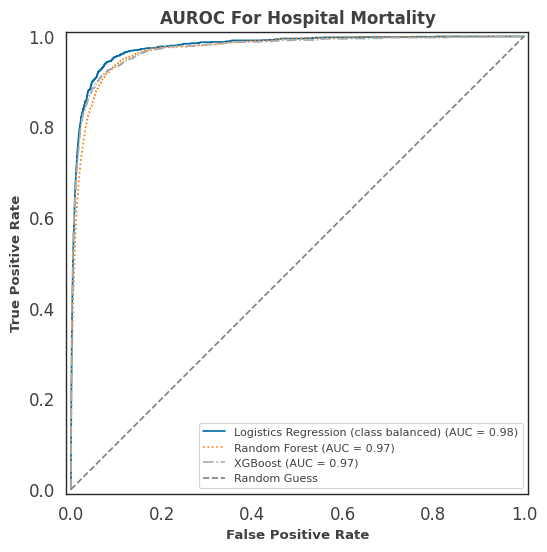

In [41]:
models = [lr, rf, xgboost]  # Replace with your actual models
model_names = ["Logistics Regression (class balanced)", "Random Forest", "XGBoost"]  # Replace with your model names
line_styles = ['-', ':', '-.']
# colors = ['blue', 'green', 'red']  # Colors for each model

plt.figure(figsize=(8, 6))

for model, name, style in zip(models, model_names, line_styles):
    # Get predicted probabilities for the positive class
    y_pred = model.predict_proba(test_X)[:, 1]  
    fpr, tpr, _ = roc_curve(test_y, y_pred)  
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=plt.gca(), linestyle=style)#, color=color)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
# Add plot title and legend
plt.title(f"AUROC For Hospital Mortality")
plt.legend(loc="lower right", fontsize=8)
plt.savefig(f"../results/auroc.png", dpi=300)

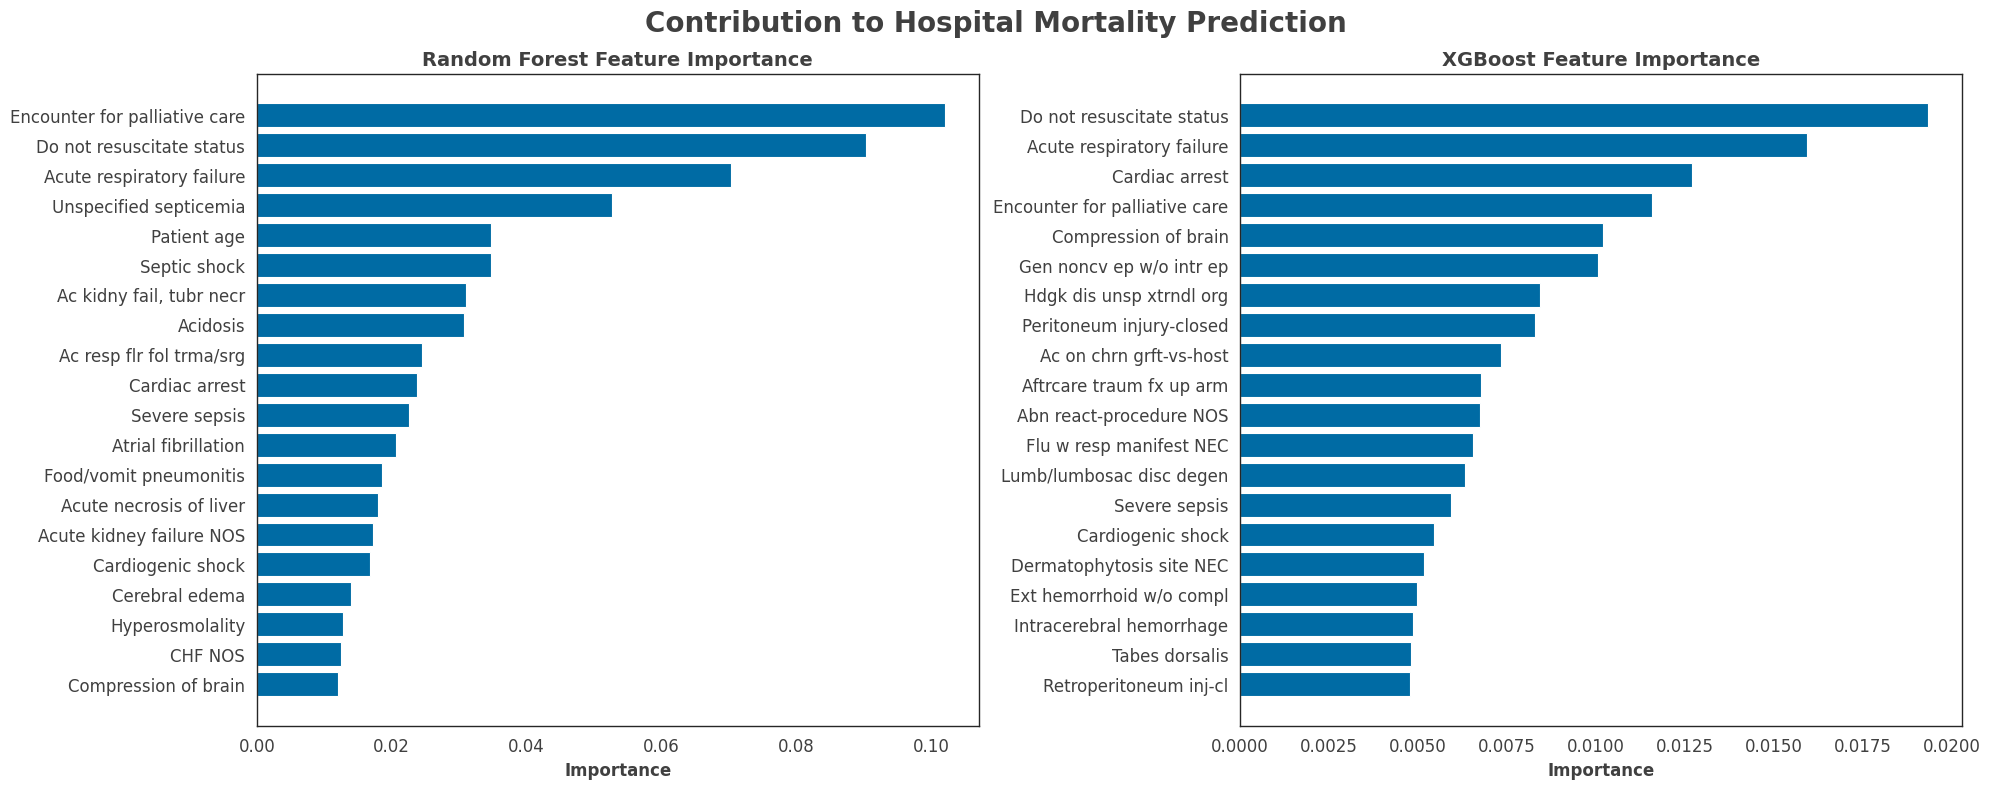

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# Model titles for the subplot
model_titles = ["Random Forest Feature Importance", "XGBoost Feature Importance"]

# Loop through both models
for i, (model, title) in enumerate(zip([rf, xgboost], model_titles)):
    ax: plt.Axes = axes[i]  # Correctly select the subplot axis
    
    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': display_titles,  # Replace 'titles' with the actual feature names list
        'Importance': model.feature_importances_
    })
    
    # Sort by importance and take top 20
    top_features = feature_importance.nlargest(20, 'Importance')
    
    # Plot feature importance
    ax.barh(top_features['Feature'], top_features['Importance'])
    ax.invert_yaxis()  # Reverse the y-axis for a better view
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Importance", fontsize=12)
    # ax.set_ylabel("Features")

# Adjust spacing between subplots
fig.suptitle("Contribution to Hospital Mortality Prediction", fontsize=20, fontweight="bold")
fig.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()
fig.savefig(f"../results/feature_importance.png", dpi=300)